#**ECE 4554/ ECE 5554 / Computer Vision**
This file contains Machine Problems 1 and 2 for Homework 4. Your job is to implement/modify the sections within this notebook that are marked with "TO DO".

##**TO DO**: Enter your Virginia Tech Username (PID) here: ankitparekh 

##**Honor Code**

Please review the Honor Code statement in the syllabus.  This is not a "team project".  *Also, if you make use of code from ANY source except the instructor, you must provide comment lines in your programs to state where you obtained that code.* Failure to cite sources of code that you borrowed will be considered a violation of the Honor Code.

##**Code libraries**
You are allowed to use NumPy and Matplotlib functions to perform matrix operations and graphics/plotting operations. You are  allowed to use OpenCV functions for graphics/plotting, such as `cv2.circle` and `cv2.line`. You are also allowed to use any OpenCV functions that are provided in this start-up notebook, but do not use any other OpenCV functions without permission from the instructor.

##**Submission guidelines** for the coding problems (Google Colab)

1. Please verify that you have entered your Virginia Tech Username in all of the appropriate places.
2. After clicking Runtime->Run all, verify that all of your solutions are visible in this notebook.
3. Click File->Save near the top of the page to save the latest version of your notebook at Google Drive.
4. Verify that the last 2 cells have executed, creating a PDF version of this notebook at Google Drive. (Note: if you face difficulty with this step, please refer to https://pypi.org/project/notebook-as-pdf/)
5. Look at the PDF file and check that all of your solutions are displayed correctly there.
6. Download your notebook file and the PDF version to your laptop.
7. On your laptop, create a ZIP version of this notebook file. (Please don't include the separate data files.) Use file name Homework4_Code_USERNAME.zip, with your own Username.
6. For your PDF version, use file name Homework4_Notebook_USERNAME.pdf, with your own Username.
7. **Submit these 2 files and your PDF file for Problems 1-4 SEPARATELY to Canvas.** Do not zip them all together.

##**Overview**

For Machine Problem 1, you will write code to find the fundamental matrix for a stereo image pair. You will also write code to display keypoints and epipolar lines in the two images. For this problem, you may assume that no outliers are present in your set of corresponding image points.

In Machine Problem 2, you will extend the previous problem by using RANSAC to address the problem of outliers. 





# Environment setup

In [6]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/MyDrive/5554/HW4')

In [8]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize 
from PIL import Image  # Python Imaging Library
# The following is a substitute for cv2.imshow, 
#  which you would use on your local machine but Colab does not support it
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
OpenCV version: 4.6.0
NumPy version:  1.21.6


#Getting started

Several image files were provided to you (Durham*.png and others). Upload them to your working directory.

The following functions are helpful for loading images into floating-point format, and for displaying images that are in that format.  Let's use those functions to display a stereo image pair. 


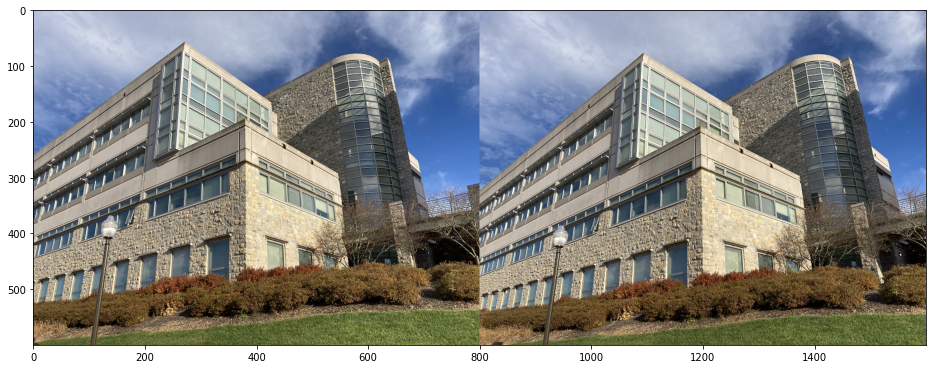

In [9]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(img)

left_img = load_image("Durham1.png")
right_img = load_image("Durham2.png")
show_image(np.concatenate([left_img, right_img], axis=1))

Now verify that you can use OpenCV tools to detect SIFT-based keypoints. The following code block should detect keypoints in one of the Durham images, and then display the image using small small circles to indicate keypoint locations.

These library functions allow for many options. For example, if you change the `nfeatures` parameter for `SIFT_create`, you'll see different numbers of detected keypoints. You may want to experiment with these parameters later.

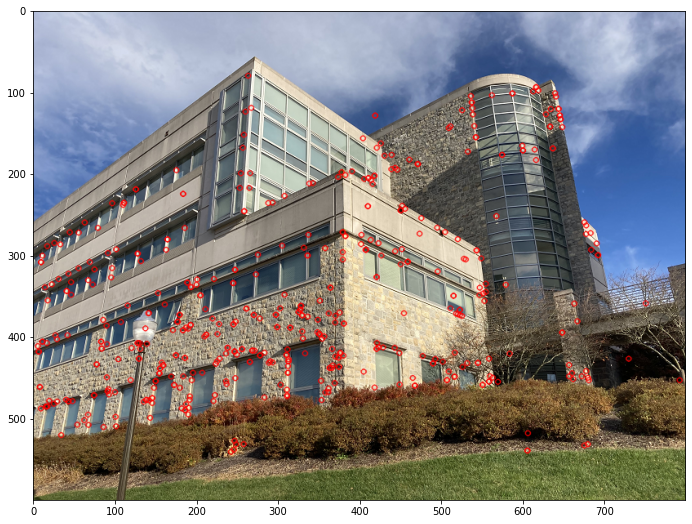

In [10]:
def testSIFT(img1):
  sift = cv2.SIFT_create(nfeatures=500)
  kp = sift.detect(img1, None)
  img1=cv2.drawKeypoints(img1, kp, None, color=(0, 0, 255))
  
  fig = plt.figure()
  fig.set_size_inches(12, 9) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))


img = cv2.imread("Durham1.png", cv2.IMREAD_COLOR)
testSIFT(img)

Next, verify that you can use a matching technique from OpenCV that tries to detect corresponding keypoints between 2 images. This example displays an example with a small number of correspondences.

The library call cv2.BFmatcher() is OpenCV's "brute force" matcher. More description is given in 
https://github.com/abidrahmank/OpenCV2-Python-Tutorials/blob/master/source/py_tutorials/py_feature2d/py_matcher/py_matcher.rst

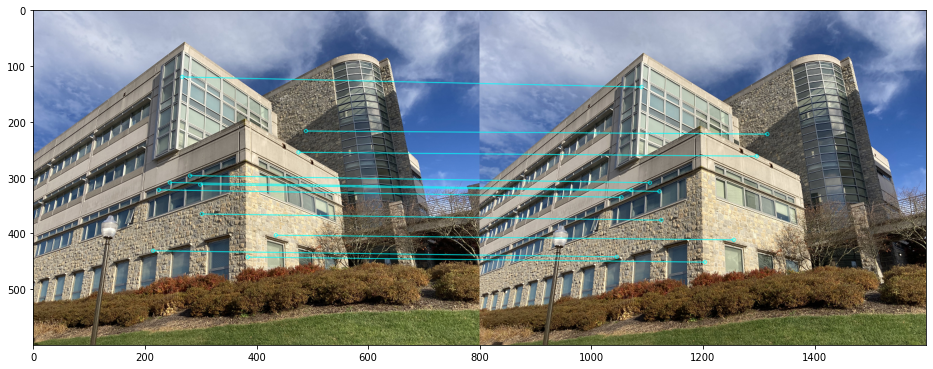

In [11]:
def genSIFTMatchPairs(img1, img2, numberOfMatches):
  # Find keypoints and their SIFT descriptors in the two images
  sift = cv2.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # Search for corresponding pairs of points 
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)

  # Sort them based on distance (dissimilarity) between two descriptors
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((numberOfMatches, 2))
  pts2 = np.zeros((numberOfMatches, 2))
  for i in range(numberOfMatches):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt
  return pts1, pts2, matches[:numberOfMatches], kp1, kp2

def testMatchingProcedure():
  img1 = cv2.imread('Durham1.png')
  img2 = cv2.imread('Durham2.png')
  
  # Perform the matching step (here, only the best 11 correspondences are returned)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 11)
  # Now pts1 and pts2 should contain lists of corresponding points 
  #  within img1 and img2, respectively
  #  Each point has the format [column row] 
  
  # Display the two images to check the results visually
  #  (the parameter flags=2 removes unmatched points from the display) 
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2,
    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))
  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))


testMatchingProcedure()

#Machine Problem 1: Fundamental matrix

The previous steps have shown how you can use OpenCV to find several pairs of corresponding points in two images. For this problem, you need to detect correspondences and use them to solve for the fundamental matrix *F* that relates the two images. You must demonstrate a correct result by using *F* to draw epipolar lines for keypoints that you detect.

The main parts of this problem are as follows:

*   **Part (a)** Write code that implements the **8-point algorithm to compute *F*.** For a given set of 8 or more correspondences, find a least-squares solution based on  those image points. An outline of the approach is given in the lecture slides: packet 17, page 23. 
*   **Part (b)** Write a function that uses *F* to **compute the epipoles** for the two images.
*   **Part (c)** Write a function to **display two images and highlight keypoints** that have been detected in both images. Also **display epipolar lines** that you obtain using your computed *F* matrix. One or both images should show epipolar lines passing through (or near) those keypoints. 
*   **Part (d)** Write a function that **combines all of the steps**, including keypoint detection and matching.

You do not need to consider outliers for this Machine Problem, and you do not need to consider additional steps that were described in the "Gold standard" algorithm from the lecture slides.

**Part 1(a).**
Implement the following function, as described above.



In [12]:
##############################
# TO DO: Implement the findFundamentalMatrix function
#  (You are allowed to subdivide your code into additional functions that are called by this one)
#
def findFundamentalMatrix(pts1, pts2, scale):
  '''Use the eight-point algorithm to compute the fundamental matrix for the given points. 
   Input:
    pts1: keypoint locations for image 1, shape (N, 2), where N >= 8
    pts2: keypoint locations for image 2, with a corresponding point for every one in pts1 
    scale: use this scale factor to convert all coordinates to the range [0, 1]
           (see the additional notes that have been provided for this problem)
   Returns:
    F: the fundamental matrix, shape (3, 3)  
  '''
  # The following line is just a placeholder. Replace it with your code.
  
  p1 = pts1/scale
  p2 = pts2/scale
  
  number_of_rows = len(p1)
  
  # intializing matrix A
  A = np.zeros((number_of_rows,9))
  
  # looping through each row in matrix A
  for i in range(number_of_rows):

    u = p1[i][0]
    u_prime = p2[i][0]
    v = p1[i][1]
    v_prime = p2[i][1]
    
    A[i] = [u*u_prime, u*v_prime, u, v*u_prime, v*v_prime, v, u_prime, v_prime, 1]
  
  # Solving for f in Af = 0 
  U,S,Vh=np.linalg.svd(A)
  F = np.reshape(Vh[-1,:],(3,3))

  # Unnormalizing F w.r.t scale
  U,S,Vh=np.linalg.svd(F)
  S[-1]=0
  F = U @ np.diag(S) @ Vh
  Un = np.array([[1/scale,0,0],[0,1/scale,0],[0,0,1]])
  F = Un.T @ F @ Un

  return F

**Part 1(b).** Write a function that uses *F* to compute the epipoles for the 
two images.

In [24]:
##############################
# TO DO: Implement the findEpipoles function
#
def findEpipoles(F):
  '''Compute the two epipoles from a given fundamental matrix
   Input:
    F: fundamental (or essential) matrix, shape (3, 3)
   Returns:
    e1, e2: the two epipoles; each is a vector with 3 components
  '''
  # The following 2 lines are just placeholders. Replace them with your code.
  U, S, V = np.linalg.svd(F)
  e1 = V[-1, :]
  e2 = U[:, -1]

  return e1, e2
  

For grading purposes, run the following code block to print your computed matrix *F* and the two epipoles for the sample points that are given below.

In [25]:
##############################
# Do not modify this code block 
#  (For debugging, you could copy this code to another block and edit it there)

# The following are some matching keypoints that were detected in the Durham1 and Durham2 images.
pts1_list = [
  [224.95256042, 321.64755249],
  [280.72879028, 296.15835571],
  [302.34194946, 364.82437134],
  [434.68283081, 402.86990356],
  [244.64321899, 308.50286865],
  [488.62979126, 216.26953125],
  [214.77470398, 430.75869751],
  [299.20846558, 312.07217407],
  [266.94125366, 119.36679077],
  [384.41549683, 442.05865479],
  [475.28448486, 254.28138733]]

pts2_list = [
  [253.88285828, 335.00772095],
  [304.884552,   308.89205933],
  [325.33914185, 375.91308594],
  [455.15515137, 411.18075562],
  [271.48794556, 322.07028198],
  [515.11816406, 221.74610901],
  [245.31390381, 441.54830933],
  [321.74771118, 324.31417847],
  [289.86627197, 137.46456909],
  [403.3711853,  451.08905029],
  [496.16610718, 261.36074829]]
 
pts1 = np.asarray(pts1_list)  
pts2 = np.asarray(pts2_list)

# Compute F and the epipoles
#  Scale factor 800 is the largest (row, column) size of the Durham images
F = findFundamentalMatrix(pts1, pts2, 800)
e1, e2 = findEpipoles(F)

# Print F and the epipoles
print('F =\n', F)
print('\n')
print('normalized epipole #1:', e1/e1[2])
print('normalized epipole #2:', e2/e2[2])  


F =
 [[ 1.40042276e-09 -4.27566912e-07  2.43313203e-04]
 [ 5.47813205e-07  9.92883549e-09  7.04216837e-04]
 [-3.05356607e-04 -7.75993616e-04  4.26336765e-02]]


normalized epipole #1: [-1.29574249e+03  5.64820637e+02  1.00000000e+00]
normalized epipole #2: [-1.80185470e+03  5.62016328e+02  1.00000000e+00]


**Part 1(c).** 
Write a function `displayEpipolarLines` that will display two stereo images and highlight keypoints in both images. Also display epipolar lines in at least one of the images. This function should display information for all of the keypoints that are provided to it. For practical reasons, usually it is best to display a small number of keypoints (e.g., 15 or 20, not 200) so that it is relatively easy to see the individual keypoints and lines. 



In [16]:
##############################
# TO DO: Implement the displayEpipolarLines function
#
def displayEpipolarLines(pts1, pts2, F, img1, img2):
  '''Display two images with highlighted keypoints and epipolar lines. 
     Assume that the keypoints have already been detected, and F has already been computed.
   Input:
    pts1: keypoint locations for image 1, shape (N, 2), where N >= 1
    pts2: keypoint locations for image 2, with a corresponding point for every one in pts1
    F:  fundamental matrix for the two images 
    img1: image 1
    img2: image 2
   Output:
    No return value; the output is a visual display  
  '''
  # write your code here

  fig = plt.figure(figsize=(15,15))

  # creating matplotlib subplot
  fig.add_subplot(1, 2, 1)
  left_plot = img1.copy() ###
  
  # drawing epipolar lines for keypoints of right image on left image (l=Fx')
  for pt2 in pts2:
      a,b,c = (F @ np.reshape(np.array([pt2[0],pt2[1],1]),(3,1)))
      point1 = (0,-int(c/b))
      point2 = (img1.shape[1], -int((a*img1.shape[1] + c)/b))
      cv2.line(left_plot, point1, point2, color=(255,0,255),thickness = 2) ###
  plt.imshow(cv2.cvtColor(left_plot, cv2.COLOR_BGR2RGB))
  plt.scatter(pts1[:, 0], pts1[:, 1], color="blue", s=50)

  # creating matplotlib subplot
  fig.add_subplot(1, 2, 2)
  right_plot = img2.copy()

  # drawing epipolar lines for keypoints of left image on right image (l'=(F.T)x)
  for pt1 in pts1:
      a,b,c = (F.T @ np.reshape(np.array([pt1[0],pt1[1],1]),(3,1)))
      point1 = (0,-int(c/b))
      point2 = (img1.shape[1], -int((a*img1.shape[1] + c)/b))
      cv2.line(right_plot, point1, point2, color=(255,0,255),thickness = 2) ###
  plt.imshow(cv2.cvtColor(right_plot, cv2.COLOR_BGR2RGB))
  plt.scatter(pts2[:, 0], pts2[:, 1], color="blue", s=50)
  
  return

Run the following code block to test your code. This test uses the precomputed set of 11 correspondences from the Durham images. (Here I'm using 11 correspondences because my least-squared results were much worse with a smaller number. Possible reasons: not well distributed spatially across the images, or lens distortion, etc.) 

Fmat =
 [[ 1.40042276e-09 -4.27566912e-07  2.43313203e-04]
 [ 5.47813205e-07  9.92883549e-09  7.04216837e-04]
 [-3.05356607e-04 -7.75993616e-04  4.26336765e-02]]


normalized epipole #1: [-1.29574249e+03  5.64820637e+02  1.00000000e+00]
normalized epipole #2: [-1.88718225e+03 -3.29525326e+01  1.00000000e+00]


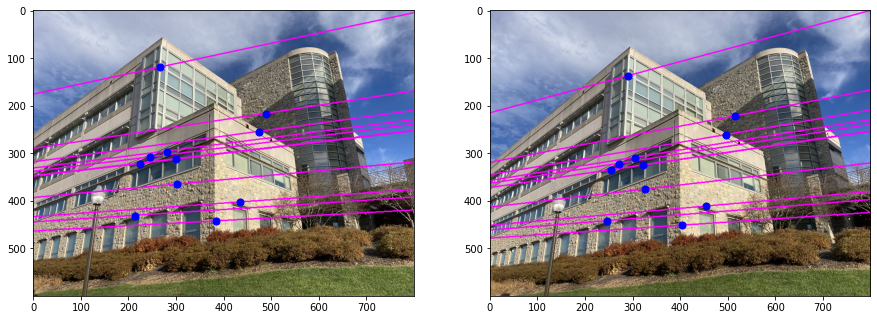

In [17]:
##############################
# Do not modify this code block 
#  (For debugging, you could copy this code to another block and edit it there)
#
def testEpipolarLines():
  img1 = cv2.imread('Durham1.png')
  img2 = cv2.imread('Durham2.png')
  
  # The following are some matching keypoints that were detected in the Durham1 and Durham2 images.
  pts1_list = [
    [224.95256042, 321.64755249],
    [280.72879028, 296.15835571],
    [302.34194946, 364.82437134],
    [434.68283081, 402.86990356],
    [244.64321899, 308.50286865],
    [488.62979126, 216.26953125],
    [214.77470398, 430.75869751],
    [299.20846558, 312.07217407],
    [266.94125366, 119.36679077],
    [384.41549683, 442.05865479],
    [475.28448486, 254.28138733]]

  pts2_list = [
    [253.88285828, 335.00772095],
    [304.884552,   308.89205933],
    [325.33914185, 375.91308594],
    [455.15515137, 411.18075562],
    [271.48794556, 322.07028198],
    [515.11816406, 221.74610901],
    [245.31390381, 441.54830933],
    [321.74771118, 324.31417847],
    [289.86627197, 137.46456909],
    [403.3711853,  451.08905029],
    [496.16610718, 261.36074829]]

  pts1 = np.asarray(pts1_list)  
  pts2 = np.asarray(pts2_list)

  # Compute F and the epipoles
  #  Scale factor 800 is the largest (row, column) size of the Durham images
  Fmat = findFundamentalMatrix(pts1, pts2, 800)
  e1tmp, e2tmp = findEpipoles(Fmat)

  # Print F and the epipoles
  print('Fmat =\n', Fmat)
  print('\n')
  print('normalized epipole #1:', e1tmp/e1tmp[2])
  print('normalized epipole #2:', e2tmp/e2tmp[2]) 
  
  # Display the two images with epipolar lines highlighted
  displayEpipolarLines(pts1, pts2, Fmat, img1, img2)


testEpipolarLines()


**Part 1(d).**
Write a function that performs the full sequence of operations: load two images, detect SIFT keypoints, perform stereo matching, compute the fundamental matrix, and display the results.

Show your results using the files `operahouse1.png` and `operahouse2.png`.
For all steps up to performing stereo matching, you may borrow liberally from the "starter code" in this notebook, although you may need to adjust some of the parameters in order to get good results. To compute the fundamental matrix, you must call your function `findFundamentalMatrix`. To display the results, you must call your function `displayEpipolarLines`.


In [18]:
##############################
# TO DO: Implement the following function 
#
def stereoMatchingAndDisplay(img1file, img2file):
  '''Extract keypoints from a stereo image pair, find corresponding points, 
      compute the fundamental matrix (assuming no outliers), 
      and display the results with sample epipolar lines. 
   Input:
    img1file: name of file containing image 1
    img2file: name of file containing image 2
   Output:
    No return value; the output is a visual display  
  '''
  # write your code here
  img1 = cv2.imread(img1file)
  img2 = cv2.imread(img2file)

  # Perform the matching step (here, only the best 11 correspondences are returned)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 15)
  pts1 = np.asarray(pts1)
  pts2 = np.asarray(pts2)
  scale = max(img1.shape[0],img1.shape[1])  
  
  Fmat = findFundamentalMatrix(pts1, pts2, scale)

  # Display the two images with epipolar lines highlighted
  displayEpipolarLines(pts1, pts2, Fmat, img1, img2)

Run the following code block to test your  `stereoMatchingAndDisplay` function.

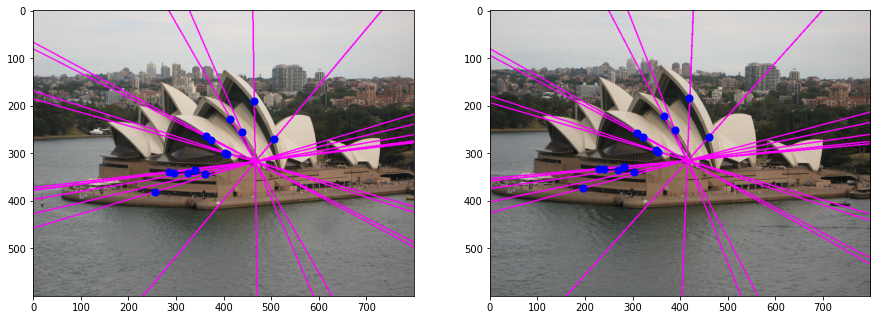

In [19]:
##############################
# Please do not change the first line of code in this block, for the operahouse pair.
#  It is okay (but not required) to add more lines that test your stereoMatchingAndDisplay 
#  function with additional stereo pairs.
#
stereoMatchingAndDisplay('operahouse1.png', 'operahouse2.png')

# Machine Problem 2: Using RANSAC to deal with outliers

In the previous problem, undoubtedly you saw that incorrect correspondences can be reported by the OpenCV tools. It is very likely that those false matches will act as outliers in your estimation of the fundamental matrix. 

As discussed during lectures, the RANSAC algorithm is a popular way to deal with outliers during model fitting. Here you must implement the RANSAC approach to compute the fundamental matrix *F*. 

A suggestion is that you detect *N*>20 correspondences from an image pair, and repeatly call your `findFundamentalMatrix` function with only 8 correspondences that are drawn at random. Based on the computed *F*, determine which correspondences are inliers, and refine your estimate of *F* using all of the inliers.

*Note that this problem is more open-ended than Machine Problem 1.* You need to make choices about what parameters to use, what input images to process, and what results to report. Use comments and print statements (as described below) to tell the grader what you have done. Try to make your explanations very clear to the grader.


In [27]:
##############################
# TO DO: Implement the following function
#  (You are allowed to subdivide your code into additional functions that are called by this one)
#

from numpy import random
def findFundamentalMatrixUsingRansac(pts1, pts2, scale):
  '''Use the eight-point algorithm  to compute the fundamental matrix for the given points,
     using RANSAC to deal with outliers. 
   Input:
    pts1: keypoint locations for image 1, shape (N, 2), where N >= 8
    pts2: keypoint locations for image 2, with a corresponding point for every one in pts1 
    scale: use this scale factor to convert all coordinates to the range [0, 1]
   Returns:
    F: the fundamental matrix, shape (3, 3)  
  '''
  # The following line is just a placeholder. Replace it with your code.
  

  # Declaring experimentation variables (number of iterations & threshold)
  # Defining a variable to experiment with the different combinations of selected points (N=8) from the given 2 sets of points (pts1, pts2)
  number_of_iterations = 100000

  # Defining a threshold value for xFx' product to classify points as inliers & outliers 
  threshold = 0.001

  # Loop for iterations
  for itr in range(number_of_iterations):
      
      # Getting a set of 8 random unique indices which can be used to pick 8 corresponiding pairs of points 
      setOfindices = set()
      while len(setOfindices) < 8:
        setOfindices.add(random.randint(0, len(pts1)))

      # Initializing lists for selected points & storing current combination of selected points in p1 & p2
      p1 = []
      p2 = []
      for index in setOfindices:
          p1.append(pts1[index])
          p2.append(pts2[index])
      p1 = np.array(p1)
      p2 = np.array(p2)

      # Finding fundamental matrix for the specific combination of p1 & p2
      F = findFundamentalMatrix(p1, p2, scale)
      
      # Initializing variable to current count of inliers in a specific combination
      count = 0
      
      # Initializing variables to store best values across all iterations
      max_inliers = 0                   # stores best value for maximum number of inliers
      best_F = np.zeros((3,3))          # stores best fundamental matrix
      best_p1 = []                      # stores best set of selected points for image 1
      best_p2 = []                      # stores best set of selected points for image 2

      # Computing number of inliers(count) for a specific Fundamental matrix
      for i in range(len(pts1)):
        pt1, pt2 = pts1[i], pts2[i]

        # bringing the points in dimensional space
        pt1 = np.append(pt1, 1)
        pt2 = np.append(pt2, 1)

        x1 = np.matrix(pt1)
        x2 = np.matrix(pt2).T

        d = abs(x1 @ F @ x2)   # d = xFx'   [X (1*3) , F (3*3), X'(3*1)]

        if d<threshold: #for points that have a d value greater than or equal to threshold, we are considering them as outliers
          count+=1

      # Re-initialization condition for best values
      if count>max_inliers:
        max_inliers = count
        best_F = F
        best_p1 = p1
        best_p2 = p2

  # Returning best values
  # print("Best F: {}".format(best_F))
  # print("Max Inliers: {}".format(max_inliers))
  # print("Best P1: {}".format(best_p1))
  # print("Best P2: {}".format(best_p2))
  return best_F, best_p1, best_p2

In the following code block, write code to test the RANSAC method that you have implemented in `findFundamentalMatrixUsingRansac`. Try to select an image pair and algorithm parameters for which RANSAC gives a good improvement over the non-RANSAC 8-point algorithm. Generate and display outputs for both cases, as a  comparison of your results *with* RANSAC and your results *without* RANSAC. Use print statements liberally to explain to the grader the different outputs that you have generated.  As part of your code's comments, describe how you decide which correspondences are outliers. (If convenient, you may also provide additional descriptions in a text block below.)

Result without using RANSAC method


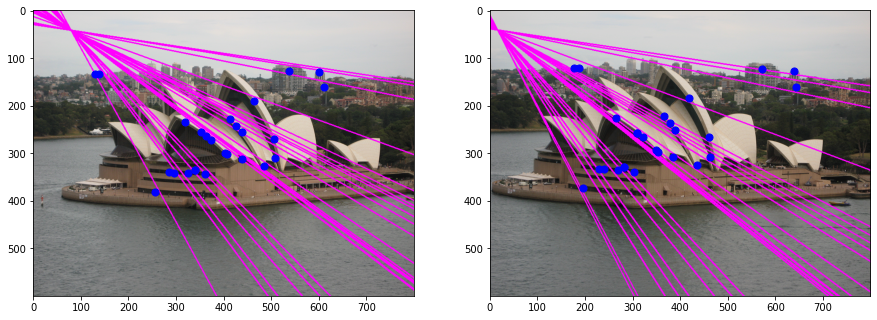

In [33]:
def getRandomPoints(pts1, pts2, n):
  idxs = set()
  while len(idxs) < n:
    idxs.add(random.randint(0, len(pts1)))
  p1 = []
  p2 = []
  for index in idxs:
      p1.append(pts1[index])
      p2.append(pts2[index])
  p1 = np.array(p1)
  p2 = np.array(p2)

  return p1, p2

img1 = cv2.imread('operahouse1.png')
img2 = cv2.imread('operahouse2.png')

# Perform the matching step (choosing 26 key-points)
pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 26)
scale =  img1.shape[0]

# Without RANSAC
print("Result without using RANSAC method")
p1, p2 = getRandomPoints(pts1, pts2, 8)
F_without_RANSAC = findFundamentalMatrix(p1, p2, scale)
displayEpipolarLines(pts1, pts2, F_without_RANSAC, img1, img2)

*   The above output is a result generated using non-RANSAC 8-point algorithm.
*   We can observe that the Epipole is far away from the center of the image.
*   A lot of Epipolar lines are not passing through the key-points which does not yield an ideal result.


Result using RANSAC method


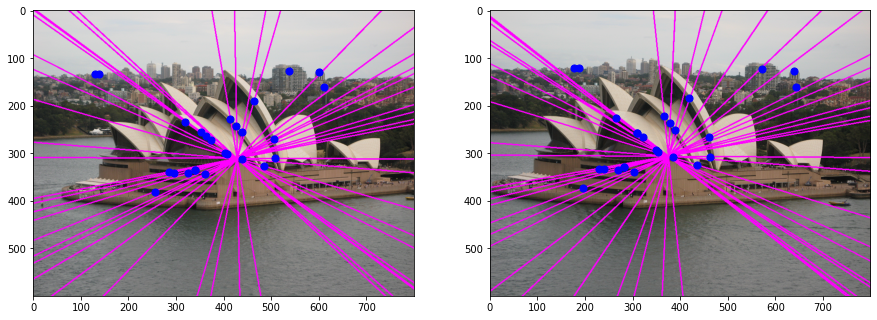

In [35]:
# With RANSAC
print("Result using RANSAC method")
F, p1, p2 = findFundamentalMatrixUsingRansac(pts1, pts2, scale)
#displayEpipolarLines(np.asarray(p1), np.asarray(p2), F, img1, img2)
displayEpipolarLines(pts1, pts2, F, img1, img2)

*   The above output is a result generated using RANSAC 8-point algorithm.
*   We can observe that the Epipole is almost at the center of the image.
*   Relatively, more number of Epipolar lines are passing through the key-points which is yielding a close to ideal result.

---
# Creating a PDF version of your current notebook

In [ ]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc

In [37]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "/content/drive/MyDrive/5554/HW4/Homework4_ankitparekh.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/5554/HW4/Homework4_ankitparekh.ipynb to PDF
[NbConvertApp] Support files will be in Homework4_ankitparekh_files/
[NbConvertApp] Making directory ./Homework4_ankitparekh_files
[NbConvertApp] Making directory ./Homework4_ankitparekh_files
[NbConvertApp] Making directory ./Homework4_ankitparekh_files
[NbConvertApp] Making directory ./Homework4_ankitparekh_files
[NbConvertApp] Making directory ./Homework4_ankitparekh_files
[NbConvertApp] Making directory ./Homework4_ankitparekh_files
[NbConvertApp] Making directory ./Homework4_ankitparekh_files
[NbConvertApp] Writing 81070 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 3487885 bytes to /